In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from IPython import display
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [4]:
class Encoder(nn.Module):
    def __init__(self, d=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28*28,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense_mean = nn.Linear(512,d)
        self.dense_log_var = nn.Linear(512,d)
        
    def forward(self, x):
        z = self.flatten(x)
        z = self.dense(z)
        z = self.leaky_relu(z)
        z_mean = self.dense_mean(z)
        z_log_var = self.dense_log_var(z)
        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self,d=10):
        super().__init__()
        self.dense = nn.Linear(d,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(512,28*28)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.dense(x)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x.view(-1,28,28)

class VAE(nn.Module):
    def __init__(self,d=10):
        super().__init__()
        self.encoder = Encoder(d)
        self.decoder = Decoder(d)
    
    def forward(self, x):
        mu, log_sigma = self.encoder(x)        
        z = mu+torch.randn(mu.shape, device=device)*torch.exp(log_sigma)
        y = self.decoder(z)
        return y, mu, log_sigma

In [5]:
criterion = nn.BCELoss(reduction='sum')

def vae_loss(x, y, mu, log_sigma):
    reconstruction_loss = criterion(y, x)
    kl_loss = -0.5*torch.sum(mu.pow(2)+log_sigma.exp()-log_sigma-1)
    
    return reconstruction_loss-kl_loss

In [6]:
model = VAE(d=10).to(device)

In [7]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

0 152.5138515372097 119.97331566856312


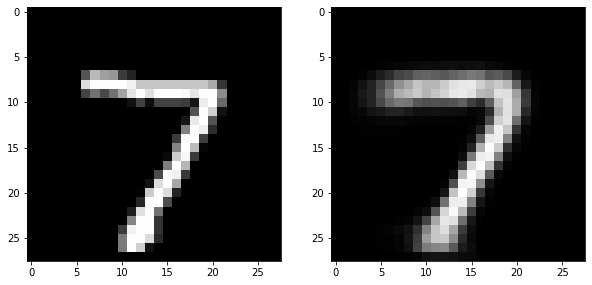

1 116.42433302607533 111.75313763115733
2 110.93492312455058 108.30985676823333
3 108.04362974187204 106.21552205923648
4 106.25109266268927 104.7673516806703
5 104.90199756961218 103.54269204429163
6 103.89932171808715 102.67376072795247
7 103.02070880122615 102.19926498949337
8 102.38291979412196 101.35542277863232
9 101.74494035581198 100.82255897887599
10 101.24753085789142 100.56688407434822
11 100.74798071562354 99.97569845278804
12 100.27579632767906 99.61842195066019
13 99.91068489058439 99.3670675015678
14 99.54791974987472 99.2192845694935
15 99.20060873133288 98.8156641024751
16 98.89068108987706 98.52172368936264
17 98.53868256482826 98.48191133931803
18 98.33001380383587 98.01948686301137
19 98.01624472156516 97.95529835368879
20 97.76966273369482 97.50765376959365
21 97.54359981534154 97.4571079339463
22 97.35149584718012 97.08512325104053
23 97.12039429123044 97.27397926013691
24 96.93887670716244 96.79555126348623
25 96.73533437873932 96.66433832820611
26 96.57730728832

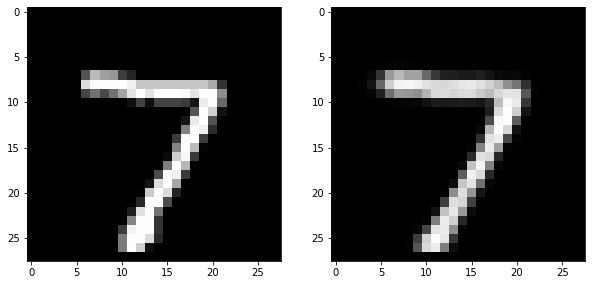

101 92.03315035366555 93.69324032719524
102 92.03727963467227 93.7567799967318
103 91.94718281326348 93.91508981137991
104 91.91832988009693 94.2192190249507
105 91.8985208594045 93.78232225899498
106 91.92447241028744 93.84195935916595
107 91.84457501029833 93.94830229640388
108 91.83793732860704 94.30985026009166
109 91.82421961217038 93.59897567212772
110 91.79101394403888 93.55117424913108
111 91.75488423860574 93.97507513369234
112 91.75671555357108 93.70220486576946
113 91.7435968394981 94.15871149130142
114 91.68117273760419 93.85725505207293
115 91.72080766993714 93.89100824910612
116 91.65194209247255 93.69859040964145
117 91.66214651339598 93.9519705482946
118 91.63945255130423 93.96922870185048
119 91.609449575027 93.99542658016705
120 91.58238248953857 93.59429366139177
121 91.52667303024324 93.68834271903236
122 91.56954893696452 93.98387494559486
123 91.53936481814733 93.6832856248362
124 91.5279778139593 93.53999389550937
125 91.5001214033505 93.79757541741807
126 91.504

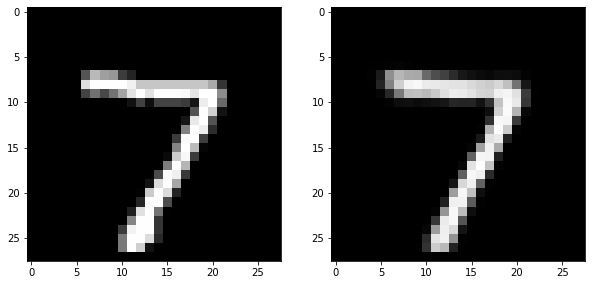

201 90.48143006455585 93.47619507030937
202 90.51902400100155 93.86017091891256
203 90.50540590049023 93.83689336807203
204 90.49015744120497 94.42411160697571
205 90.46933127093502 93.29301186948538
206 90.43950308208018 93.41720208116233
207 90.45572807675316 94.40479151814128
208 90.46177055722191 93.65903204774705
209 90.41816937542166 93.47436833000792
210 90.39341966836437 93.56124412365996
211 90.403149293684 93.61265239776513
212 90.43940808066426 93.55793837769724
213 90.37905747685436 93.4522905441138
214 90.41309147924926 93.63994559388573
215 90.36724056414704 93.84776469465262
216 90.39604134413904 93.4352779693116
217 90.35927861043555 93.51195613873271
218 90.3857634272572 93.47580955432245
219 90.36014675636535 93.5867470689475
220 90.3868241354177 93.55940517145224
221 90.35174973737965 93.39122218902881
222 90.30185427797883 93.77446702951059
223 90.29839676326272 93.47211643986809
224 90.29302494832618 93.69549999297998
225 90.30498182002586 94.13434337579405
226 90.

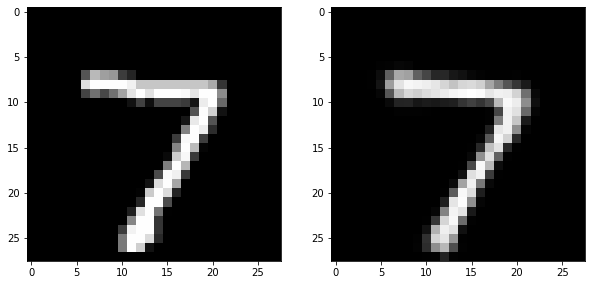

301 89.80356833234949 93.59164384835825
302 89.79786714663638 93.30465729929769
303 89.77481001018207 93.45495744406605
304 89.76049630084442 93.42926040015662
305 89.80287199691415 93.41401808863631
306 89.79043822027558 93.64532670578636
307 89.7537599846922 93.77421426011351
308 89.77374389583368 93.76270403877234
309 89.7465879200364 93.78615482318135
310 89.78609037636524 93.6071537493136
311 89.7403022858295 93.67709194585538
312 89.7892812689569 93.82227925065988
313 89.72020081043581 93.4869445703281
314 89.78189962640585 93.43727250754262
315 89.72154968413547 93.46066020929014
316 89.77188431360912 93.3937060566375
317 89.71839256801755 93.6660799995398
318 89.74219862145571 93.61284695951322
319 89.72194920521555 93.82699009709465
320 89.72389158290925 93.41550616182077
321 89.69962174145144 94.1884196467293
322 89.70524932275703 93.413407420198
323 89.70499953193367 93.73775781991002
324 89.70141149329733 93.70868656048759
325 89.66773111632129 93.65689320914662
326 89.6952

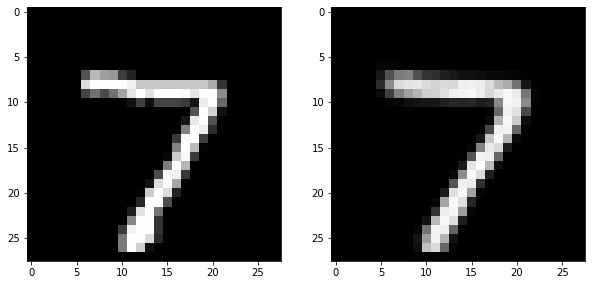

401 89.35623028503723 93.52146419244833
402 89.3808282121497 93.55535055044741
403 89.32733406983289 93.91875740514396
404 89.36462061271314 94.06616922689322
405 89.33246366911605 93.87103517672506
406 89.34227380705117 93.83785903491913
407 89.33726004767944 93.75111732848536
408 89.39047894616795 93.94218396074093
409 89.29513714647327 93.47760663017297
410 89.310358347076 93.54130776012286
411 89.33849930102383 94.54951121174871
412 89.37099837443468 93.55847438531943
413 89.32893155226067 94.23136348541553
414 89.30022252021143 93.36081517618685
415 89.29038970014604 93.5809807823108
416 89.35295895032199 93.718126169028
417 89.34934416271392 93.64153031419261
418 89.29766167896219 93.49353283281906
419 89.26765110582515 93.4946139887118
420 89.29858015069914 93.45521740410655
421 89.30086689225816 94.0437124575289
422 89.33659616563874 93.70394568397595
423 89.27899043036422 93.69681139571217
424 89.31334770869599 94.00648659410568
425 89.27995472727045 93.95897330872167
426 89.2

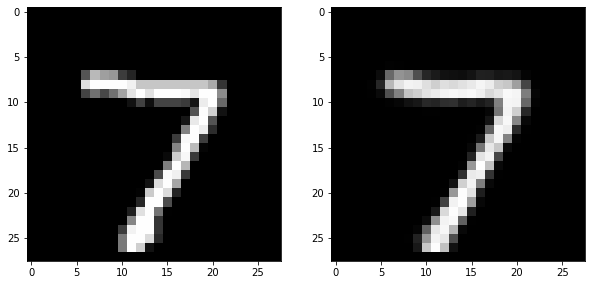

In [8]:
n_epochs = 501

losses = []
val_losses = []

for e in range(n_epochs):    
    loss_epoch = 0
    cpt_batch = 0
    
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        
        model.train()
        
        yhat, mu, log_sigma = model(x_batch.reshape(-1,28,28))
        yhat = yhat.reshape(-1,1,28,28)
        
        l = vae_loss(x_batch, yhat, mu, log_sigma)
        
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_epoch += l.item()/x_batch.size(0)
        cpt_batch += 1

    losses.append(loss_epoch/cpt_batch)
    
    loss_val_epoch = 0
    cpt_batch = 0
        
    with torch.no_grad():
        for x_val, _ in test_loader:
            x_val = x_val.to(device)
            
            model.eval()
            yhat, mu, log_sigma = model(x_val.reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            
            val_l = vae_loss(x_val,yhat,mu,log_sigma)
            loss_val_epoch += val_l.item()/x_val.size(0)
            cpt_batch += 1
            
        val_losses.append(loss_val_epoch/cpt_batch)

    print(e,losses[-1],val_losses[-1])
        
    if e%100 == 0:  
        for x_val, _ in test_loader:
            fig,ax = plt.subplots(1,2,figsize=(10,10))

            ax[0].imshow(x_val[0][0],"gray")

            x_val = x_val.to(device)

            model.eval()
            yhat, mu, sigma = model(x_val[0][0].reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
            plt.show()
            break
        

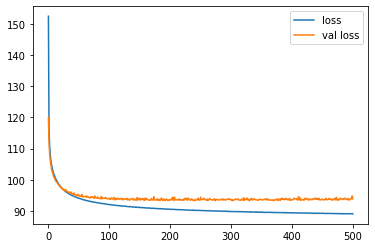

In [9]:
plt.plot(losses,label="loss")
plt.plot(val_losses,label="val loss")
plt.legend()
plt.show()

To do:.
- Log Likelihood estimation